We would like to know, qualitatively, what we would expect a fully random distrbution of Gd in AlN would look like, in terms of distribution of brightness. Here, we construct a randomly distributed supercell of AlGdN with a moderate amount of Gd, simulate its appearance in an ADF image, and (qualitatively) look at the distribution of brightnesses.

In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilename, asksaveasfilename

import abtem
import numpy as np
from copy import deepcopy
import ase.io as aio
from ase import Atoms
from ase.build import surface
from ase.visualize.plot import plot_atoms
from random import randint, seed, shuffle
from sys import maxsize

from sim_stem import simulate_stem, preview_stem_result

In [2]:
def tk_popover(save: bool = False, **kwargs):
    """Tk helper to ensure window appears on top."""
    root = Tk()
    root.iconify()
    root.attributes('-topmost', True)
    root.update()
    loc = None  # Default return if open fails; will likely cause an error when passed along
    try:
        if not save:
            loc = askopenfilename(parent=root, **kwargs)
        else:
            loc = asksaveasfilename(parent=root, **kwargs)

    finally:
        root.attributes('-topmost', False)
        root.destroy()
    return loc

# Simulation

In [3]:
# Setup abTEM / Dask parameters
abtem.config.set({"device":              "cpu",  # Configure abTEM to run on the GPU
                  "dask.lazy":           True,  # Setting to False can be useful for debugging
                  "dask.chunk-size":     "128 MB",  # 128 MB is the standard L3 cache size (per core)
                  "dask.chunk-size-gpu": "512 MB",  # Remember to leave space for overhead
                  "scheduler":           "threads",  # Threads or processes
                  "num_workers":         48  # Number of threads/processes to use for simulation (set to 1 for gpu)
                  })

<Axes: >

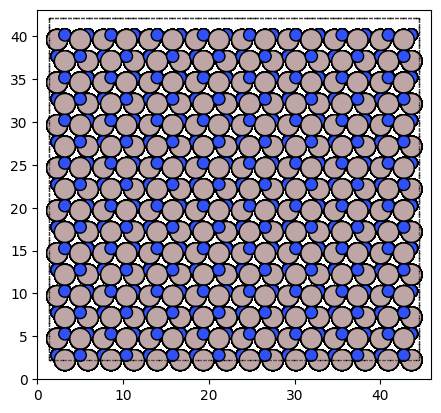

In [4]:
%matplotlib inline

# Open .cif & generate the potential
thickness: float = 200  # Angstrom; total thickness (z direction)
reps: int = 8  # How many repeats to have in x and y directions

cifpath = Path(tk_popover())  # Open AlN .cif file
uc = aio.read(cifpath)

# Get spanning vectors for the projected cell
# We do this with a temporary structure so we can set layers=1
c = np.linalg.norm(surface(uc, indices=(1, 1, 0), layers=1, periodic=True).cell[2])

surf = surface(uc, indices=(1, 1, 0), layers=int(thickness//c + 1), periodic=True)
slab = abtem.orthogonalize_cell(surf)
slab *= (reps, reps, 1)
plot_atoms(slab)

The following cells create a random distribution of Gd in the AlN supercell at a specified bulk composition. The cell is _not_ relaxed.

In [5]:
def randomize_chem(atoms: Atoms,
                   replacements: dict[str, dict[str, float]],
                   prseed: int = randint(0, maxsize))\
        -> Atoms:
    """Randomize the chemistry of an ASE ``Atoms`` object via to user-defined replacement rules.

    Parameters
    ----------
    atoms : Atoms
        Initial ASE ``Atoms`` object.  A changed copy of this object will be returned.
    replacements : Dict[str, Dict[str, float]]
        Replacement dictionary.  The keys should be the symbols of the initial elements to replace,
        and the values should themselves be dictionaries.  The value dicts should have keys which
        are the elements that will replace the corresponding initial element, and the values
        should be floats representing the fraction of the initial element to replace with the given
        element.  The sum of the floats must be <= 1 for each initial element.  For example:
            >>> {"Ba": {"Sr": 1},
            >>>  "Ti": {"Zr": 0.4,
            >>>         "Nb": 0.05}}
        would replace all Ba atoms in ``atoms`` with Sr, would randomly replace 40% of Ti atoms in
        ``atoms`` with Zr, and randomly replace 5% (of the initial amount of Ti) with Nb.
    prseed : int, optional
        Pseudo-random seed.  The default is to randomly choose a seed between 0 and sys.maxsize.

    Returns
    -------
    Atoms
        ASE ``Atoms`` object based on ``atoms``, but with the specified elemental replacements.
    """
    seed(prseed)
    new_atoms = deepcopy(atoms)

    # Add in NOP weights and then sanity check
    for elem, reps in replacements.items():
        if sum(reps.values()) < 1:  # Add in the "NOP weights" (chance to not replace) if needed
            reps[elem] = 1 - sum(reps.values())
        if sum(reps.values()) != 1:  # If this is ever False, we're likely to get garbage results
            raise RuntimeError(f"Sum of rep values ({sum(reps.values())}) not equal to 1!")

    symbols = new_atoms.get_chemical_symbols()
    uniques = list(set(symbols))  # Since set iteration order is not guaranteed, cast back to a list
    counts = dict(zip(uniques, [symbols.count(e) for e in uniques]))

    for elem, reps in replacements.items():
        elem_idxs = [idx for idx, sym in enumerate(symbols) if sym == elem]
        k = counts[elem]
        rep_counts = [round(k*w) for w in reps.values()]
        n = sum(rep_counts)

        while n != k:  # Counts may be off due to cumulative rounding error
            diffs = [c/k - w for w, c in zip(reps.values(), rep_counts)]
            if n < k:  # Since we have too few reps, we want to add one to the most negative diff
                mindex = diffs.index(min(diffs))
                rep_counts[mindex] = rep_counts[mindex] + 1
            elif n > k:  # Since we have too many reps, we want to remove one from the most positive diff
                maxdex = diffs.index(max(diffs))
                rep_counts[maxdex] = rep_counts[maxdex] - 1
            n = sum(rep_counts)

        rep_with = [x for sublist in  # Outer list comprehension to make sure we get a flat list
                    [[e]*c for e, c in zip(reps.keys(), rep_counts)]
                    for x in sublist]
        shuffle(rep_with)  # Now the only random step in this whole process is the shuffle

        for i in elem_idxs:
            symbols[i] = rep_with.pop()

    new_atoms.set_chemical_symbols(symbols)
    return new_atoms

<Axes: >

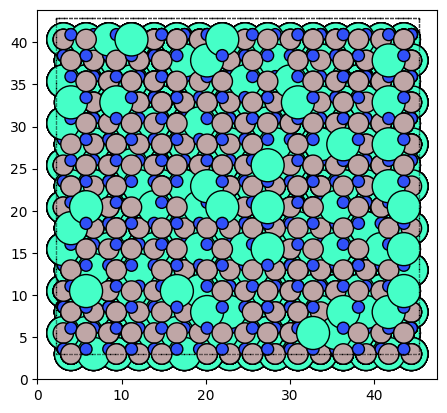

In [37]:
# Check 2 comps (13%, 17%), each with seeds: 554520389, 431247922, 120304979 (all from random.org)
substituted_slab = randomize_chem(slab, {"Al": {"Gd": 0.17}}, prseed=431247922)
plot_atoms(substituted_slab)

In [38]:
sigs = {"Al": 0.0748,  # Source: 10.1017/S0885715614000542
        "Gd": 0.1000,  # Source: rough est. from 10.1088/1742-6596/417/1/012049 & 10.1063/1.3658845
        "N":  0.0841}  # Source: 10.1017/S0885715614000542

fps = abtem.FrozenPhonons(substituted_slab,
                          num_configs=10,
                          sigmas=sigs,
                          ensemble_mean=True)

In [39]:
# Creating the potential takes couple minutes
potential = abtem.Potential(fps,
                            sampling=0.04,
                            projection="infinite",
                            parametrization="kirkland",
                            slice_thickness=2)
detector = abtem.detectors.AnnularDetector(46, 200)

[########################################] | 100% Completed | 827.95 ms


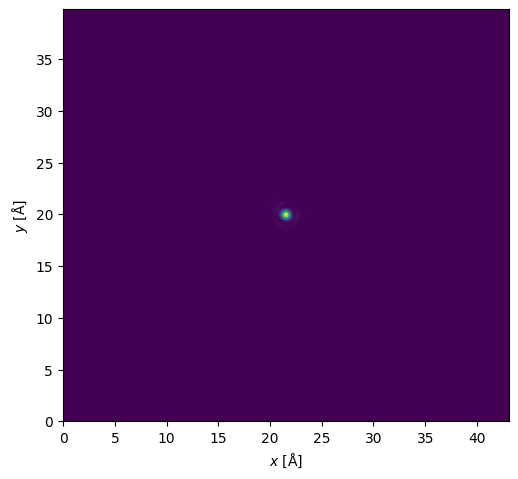

In [40]:
# Probe aberrations (based on Themis), up to 5th order; units are Angstrom & radian
aberrations = {"C10":   22,     # Defocus (C1)
               "C12":   7,      # 2-fold stig (A1)
               "phi12": 2.71,   # 2-fold stig angle
               "C21":   335,    # Coma (B2)
               "phi21": 2.67,   # Coma angle
               "C23":   480,    # 3-fold stig (A2)
               "phi23": 0,      # 3-fold stig angle
               "C30":   -5200,  # Spherical aber (C3 / CS)
               "C32":   7600,   # "Star" aber (S3)
               "phi32": -0.37,  # Star aber angle
               "C34":   3900,   # 4-fold stig (A3)
               "phi34": -1.71,  # 4-fold stig angle
               "C41":   8.4e4,  # 4th order coma (B4)
               "phi41": -0.24,  # 4th order coma angle
               "C43":   1.4e5,  # Three-lobe aber (D4)
               "phi43": 1.40,   # Three-lobe aber angle
               "C45":   1.1e4,  # 5-fold stig (A4)
               "phi45": 1.40,   # 5-fold stig angle
               "C50":   -8e6,   # 5th order spherical aber (C5)
               "C52":   9.7e5,  # 5th order star aber (S5)
               "phi52": 2.04,   # 5th order star aber angle
               "C54":   3.2e5,  # Rosette aber (R5)
               "phi54": -2.09,  # Rosette aber angle
               "C56":   2.8e6,  # 6-fold stig (A5)
               "phi56": 0.98    # 6-fold stig angle
               }

# View probe and verify profile before simulating
# Adding these aberrations has little effect on the FWHM, but changes the tails and reduces the max intensity slightly
abtem.Probe(semiangle_cutoff=17.9, energy=200e3, aberrations=aberrations).match_grid(potential).show()

In [41]:
# TODO: Simulation seems to hang/crash using PRISM, no explanation as to why...

fpath = tk_popover(save=True)  # Setup filename before running the simulation, so we can save automatically
result = simulate_stem(potential=potential, detectors=detector, convergence=17.9, aberrations=aberrations, eager=True)
result.to_tiff(fpath)
preview_stem_result(result)

Simulating...
[####################################    ] | 92% Completed | 29hr 48m


MemoryError: Unable to allocate 4.10 MiB for an array with shape (1078, 996) and data type float32